# Advanced Statistics for Physics Analysis - Final assignment
## Learning the topology of a bayesian network from a database of cases using the K2 algorithm

Buriola Lorenzo - 2021860

Campesan Giulia - 2027592

Marcomini Alessandro - 2024286

### Introduction

In the framework of Bayesian Networks, learning the structure of a DAG, knowing the casual dependacies between nodes, is one of the most challenging tasks. Usually the space of possible networks is huge, expecially with a large number of nodes, and there is not a defined metrics to explore it. 
Many algorithms, that allow, given a set of nodes and data, to learn the structure of a Bayesian Network, have been proposed following different approaches (see [6](#reference_cell)). Among these the _score-based_ algorithms solve the task as an optimization problem: every possible candidate network is assigned a score which reflects how well the DAG explains the dependence structure of data. The best network returned by the algorithms will be the one with the highest score.

In this notebook the _K2 algorithm_ is studied and implemented in _R_ language. This is a _score-based_ algorithm introduced by Cooper and Herskovits (see [1](#reference_cell)) in 1992. This is the functionality:
* The algorithm requires a dataset and an ordered list of nodes where no linkage are permitted in ascending order.
* For every node the algorithm begins making an assumption that there is no parent and perform a greedy-search adding parents-nodes that increase the score of the netwotk.
* When the addition of no single parent can increase the probability the algorithm stops and passes to the following node.

Note that the _score_ used is the k2 score which is an estimation of the posterior probability of the network (given the fact that all allowed configuration are equally probable at the beginning).

In [2]:
library(bnlearn)
library(lattice)
library(bnstruct)
library(Rgraphviz)

### Algorithm implementation in R
The pseudo-code for the algorithm is provided in [2](#reference_cell) together with the explicit calculations for the first dataset we investigate below. Here we define the whole loop as a function of the dataset and the maximum number of parents we allow a given node to have. Please notice that the original algorithm requires also an ordered list of the nodes, to set possible conditional dependences. To simplify the inputs, we require in here that the input dataset has its columns already ordered so to match the node list mentioned above. Finally, we make use of the "bnlearn" package to infer the conditional probabilities of the arcs and of the "Rgraphviz" package of R to plot the Bayesian network.

In [3]:
k2.algorithm <- function(data, max.parents, output.prob=TRUE){
    
    nodes <- names(data)
    n <- ncol(data)
    k2.score <- 0
    output.list <- list()
    
    dag <- empty.graph(nodes=nodes)
    
    for (i in 1:n) {
        parent <- character()
        p.old <- log.score(i, parent, data)
      
        proceed <- TRUE
        pred_xi <- nodes[1:i-1]
        
        while (proceed & (length(parent)<max.parents)) {
            
            set <- setdiff(pred_xi, parent)
            unions <- lapply(set, union, parent)
            new.parent <- unlist(unions[which.max(sapply(unions, function(x) log.score(i, x, data)))])
            p.new <- log.score(i, new.parent, data)
                                                        
            if ( p.new > p.old ) {
                p.old <- p.new
                parent <- new.parent
                for (p in new.parent){
                      dag <- set.arc(dag, from=p, to=nodes[i])
                }
            }
            else {
                proceed <- FALSE
            } 
        }
    
        k2.score <- k2.score+p.old
    }
    
    if (output.prob){
        D_c <- data.frame(apply(data,c(1,2),as.character), stringsAsFactors = TRUE)
        print(bn.fit(dag, data = D_c, method = 'bayes'))
    }                                                     
                                                         
    graphviz.plot(dag)                                                     
    output.list["log.score"] <- k2.score
    output.list["dag"] <- list(dag)
    return(output.list)                                                  
}

The code above makes use of a scoring function to rank the most probable parents sets. This is provided in che cell below, according to the theoretical model:

$$
f(i,\pi_i) = \prod_{j=1}^{q_i}\left[\frac{\left(r_i - 1\right)!}{\left(N_{ij} + r_i - 1\right)!}\prod_{k=1}^{r_i}\alpha_{ijk}!\right]
$$

Where we used the notation expressed in [2](#reference_cell). It is important to notice that at the beginning of each iteration of the algorithm, since it works in a gridding way by filling subsequently an initially empty set of parents for each node $i$, the value of $q_i$ always starts with $0$ and thus we must be careful on the first product which ranges from $j=1$ to $j=0$. In fact, we cannot use the standard convention since this will lead to $f(i,\emptyset) = 1$, so maximum probability, and thus the algorithm will be stuck assigning to each node no parents. Hence, as suggested in [2](#reference_cell), we simply ignore the $j$ index. Indeed, this allows to simplify the equation above and since the case of empty parents set is quite frequent in input we profile the function so to distinguish the cases.

The $\alpha$ values, consisting on the number of counts of a given parents sequence in the dataframe, are naturally returned by the "table( )" method of data.frame in R. 

In [4]:
#Calculate posterior probability of parents pi of node i
myscore <- function(i, pi, D){
    # number of possible ourcomes for node i
    r <- length(unique(D[,i]))  
    # generalized formula for no-parent case (from paper)
    if (length(pi) == 0){
        alpha <- table(D[i])
        N <- sum(alpha)
        prob <- factorial(r-1)/factorial(N+r-1)*prod(sapply(alpha,factorial))
    }
    # standard formula (from paper)
    else{ 
        D2 <- cbind(D[i],D[pi])
        alpha <- table(D2)
        if (length(dim(alpha))>2){dim(alpha)<-c(r,length(alpha)/r)}
        alpha <- t(alpha)
        N.j <- rowSums(alpha)
        M.j <- apply(apply(alpha, c(1,2), factorial),1,prod)
        prob <- prod(apply(cbind(N.j,M.j),1, function(x) x[2]*factorial(r-1)/factorial(x[1] + r - 1))) 
    }
}          

Since the product operations componing the score function can be expansive for large dataset, we implement also a logarithmic version of it. This allows to simply commputations turning products into sum. Eventually it will be sufficient to take the exponential of the log-score to retrive the posterior probability of a specific network. Exploting the probability of logarithms and recalling that 
$$
\log(n!) = \log\left(\prod_{x=1}^n x \right) = \sum_{x=1}^n \log(x)
$$
The log-score becomes:

$$
L := \log(f) = \sum_{j=1}^{q_j} \log_{f_j} \text{ where } \\
     \log(f_j) = \log\left[\left(r_i - 1\right)!\right] - \log\left[\left(N_{ij} + r_i - 1\right)!\right] + 
\log\left[\prod_{k=1}^{r_i}\alpha_{ijk}!\right] = \\
   = \sum_{x=1}^{r_i - 1}\log(x) - \sum_{y=1}^{N_{ij} + r_i - 1}\log(y) + \sum_{k=1}^{r_i}\sum_{z=1}^{\alpha_{ijk}}\log(z)
$$

As one might see, the log-score function can be simply obtained by summing logarithm of sequence of values, which is easy in R due to the comfort of the "apply" family methods. This is expecially helpful for large datasets, given the fact that it allows to avoid calculating very large factorials. It is worth noticing that the score function aims to find the most probable network structure. Hence, if we are not interested in the final probability of the network but only in determining the most probable one, we can simply compare the log-score (without taking the exp).

In [5]:
#Calculate posterior probability of parents pi of node i
log.score <- function(i, pi, D){
    # number of possible ourcomes for node i
    r <- length(unique(D[,i])) 
    # generalized formula for no-parent case (from paper)
    if (length(pi) == 0){
        alpha <- table(D[i])
        N <- sum(alpha)
        prob <- (ifelse(r<=1,0,sum(sapply(1:(r-1),log)))-sum(sapply(1:(N+r-1),log))+sum(sapply(alpha,function(a) ifelse(a==0,0,sum(sapply(1:a,log))))))                                                                    
    }
    # standard formula (from paper)
    else{ 
        D2 <- cbind(D[i],D[pi])
        alpha <- table(D2)
        if (length(dim(alpha))>2){dim(alpha)=c(r,length(alpha)/r)}
        alpha <- t(alpha)
        N.j <- rowSums(alpha)
        M.j <- apply(apply(alpha,c(1,2),function(a) ifelse(a==0,0,sum(sapply(1:a,log)))),1,sum)
        prob <- (sum(apply(cbind(N.j,M.j),1, function(x) sum(sapply(1:(r-1),log))-sum(sapply(1:(x[1]+r-1),log))+x[2])))
        }
        prob
}          

### Application to a simple dataset
To test the efficiency of our implementation, we aim to reproduce the results obtained in [2](#reference_cell) for the simple dataset defined below:


In [6]:
#First dataset
x1 <- c(1,1,0,1,0,0,1,0,1,0)
x2 <- c(0,1,0,1,0,1,1,0,1,0)
x3 <- c(0,1,1,1,0,1,1,0,1,0)

D <- data.frame(x1, x2, x3)
D

x1,x2,x3
<dbl>,<dbl>,<dbl>
1,0,0
1,1,1
0,0,1
1,1,1
0,0,0
0,1,1
1,1,1
0,0,0
1,1,1


We select as imput ordering the sequence: "$x_1, x_2, x_3$". Hence, the dataframe is already prepared and the run is simply given by:


  Bayesian network parameters

  Parameters of node x1 (multinomial distribution)

Conditional probability table:
   0   1 
0.5 0.5 

  Parameters of node x2 (multinomial distribution)

Conditional probability table:
 
   x1
x2          0         1
  0 0.7727273 0.2272727
  1 0.2272727 0.7727273

  Parameters of node x3 (multinomial distribution)

Conditional probability table:
 
   x2
x3           0          1
  0 0.77272727 0.04545455
  1 0.22727273 0.95454545



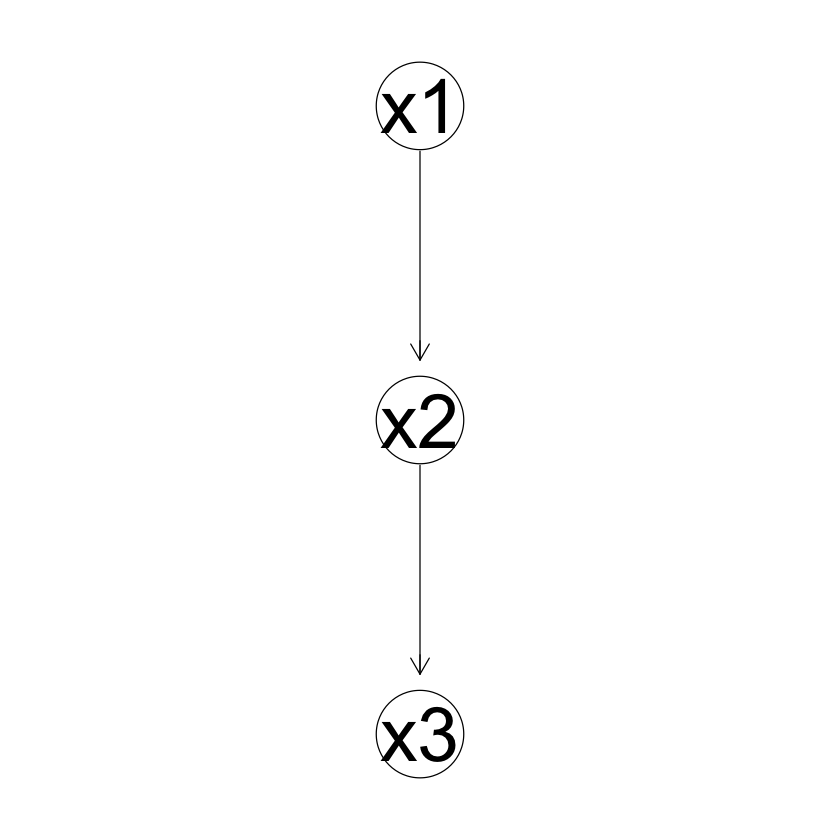

In [7]:
mynet <- k2.algorithm(data = D, max.parents = 2)

Which is the most probable structure, as reported in [2](#reference_cell). We also performed a one-on-one comparison between the posterior probabilities of all sets of parents for each node in our code and on the original paper, obtaining identical results. The score of this structure is simply given by:

In [8]:
mynet$log.score

[1] -19.92268

### Comparison with results of "bnlearn" package
Here we compare the results of our implementation with the ones returned by the "bnlearn" package applied to the previous dataset, while using the "hill climbing" (HC) algorithm and the K2 score already built-in. 


  Bayesian network parameters

  Parameters of node x1 (multinomial distribution)

Conditional probability table:
   0   1 
0.5 0.5 

  Parameters of node x2 (multinomial distribution)

Conditional probability table:
 
   x1
x2          0         1
  0 0.7727273 0.2272727
  1 0.2272727 0.7727273

  Parameters of node x3 (multinomial distribution)

Conditional probability table:
 
   x2
x3           0          1
  0 0.77272727 0.04545455
  1 0.22727273 0.95454545


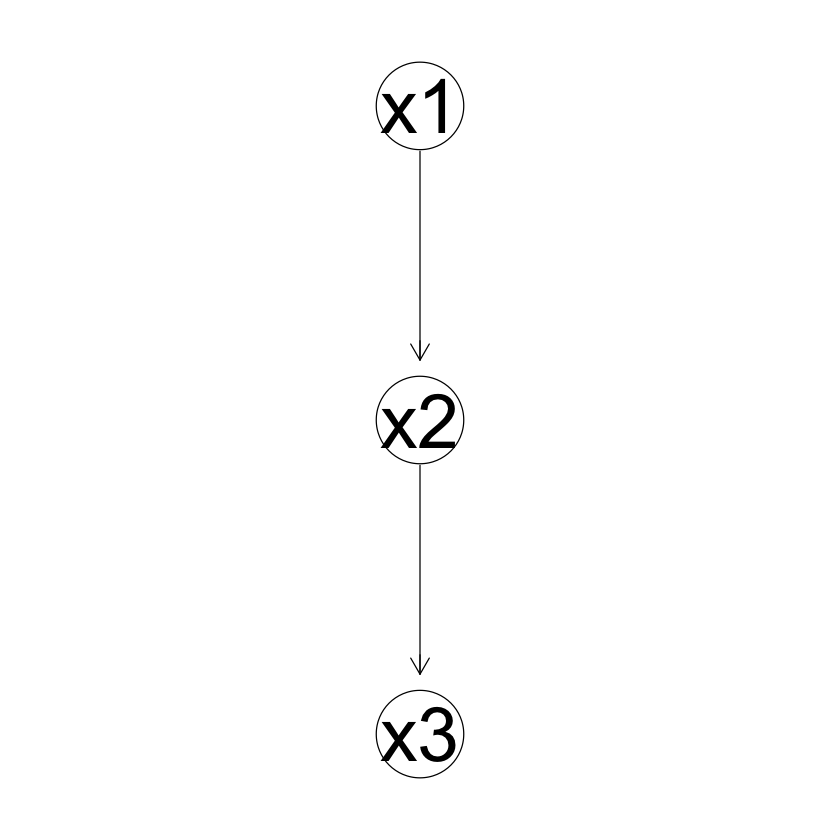

In [9]:
D_c <- data.frame(apply(D,c(1,2),as.character), stringsAsFactors = TRUE)

blacklist <- data.frame(from  = c('x2', 'x3', 'x3'), to = c('x1', 'x1', 'x2'))

net <- hc(D_c, score = 'k2', blacklist = blacklist, maxp = 2)

fit <- bn.fit(net, data = D_c, method = 'bayes')

graphviz.plot(net)
fit

As we can see, the most probable network found by "bnlearn" is the same of our implementation.

### Implementing the K2 score in the "bnstruct" package
We modified the source code of the "bnstruct" package of R in order to make available the log-score function above as a part of the already existing algorithms of bayesian network estimation. In particular, we studied the package syntax so to notice that the default method for all the learning algorithms is the so-called "Bayesian Dirichlet equivalent uniform" (BDeu) scoring function. A detailed analysis of the Bayesian Dirichlet functions is provided in [4](#reference_cell), together with the analytic form of the function:

$$
BDeu(i, \pi_i; \pmb{\alpha}) = \prod_{j=1}^{q_i} \left[ \frac{\Gamma(\alpha_{ij})}{\Gamma(\alpha_{ij} + N_{ij})} \prod_{k=1}^{r_i} \frac{\Gamma(\alpha_{ijk} + N_{ijk})}{\Gamma(\alpha_{ijk})}
\right]
$$

Where $N_{ijk}$ in the equation right above takes the place of the $\alpha_{ijk}$ term in the definition of the K2 score and $\alpha_{ijk}$ are parameters of the model with $\alpha_{ij} = \sum_k \alpha_{ijk}$ (we apologize for the confusion given by sticking to papers' notation). 

In particular, as reported in [4](#reference_cell), different choices of the parameters $\alpha_{ijk}$ allow to reach different distributions and to define a whole family of methods. Recalling that $\Gamma(x) = (x-1)!$ it is straightforward to see that fixing:
$$
\alpha_{ijk} \equiv 1 \ \forall i,j,k \implies \alpha_{ij} = r_i
$$
The equation aboves becomes the original K2 score. 

So we proceeded as follows: firstly, we downloaded the source code of the package and learned the multiple dependences of the declared methods; then, we added the K2 log-score function to the built-in scoring methods BDeu, Akaike's information criterion (AIC) and Bayesian information criterion (BIC). We finally modified all due dependences so to make the build of the renewed package working on a local computer and installed it instead of the original one. It is worth saying that the K2 score works inside the structure provide by the built-in algorithms and not (so far) inside its own K2 algorithm. As a result, its combination with particular techniques could not lead to optimal outcomes. However, our tests suggest that the implementation is quite robust for the HC algortihm mentioned above. 

The results can be seen in the following paragraphs, in which we compare the outputs of the base-R K2 algorithm, the ones of the modified "bnstruct" package and the ones of some native methods of both "bnstruct" and "bnlearn" packages. Overall, performances are promising.

#### Test on the first dataset

In [10]:
BND <- BNDataset(data = D,
                discreteness = rep('d', ncol(D)),
                variables = names(D),
                node.sizes = c(2,2,2),
                starts.from = 0)

bnet <- learn.network(BND, layering = c(1,2,3), scoring.func='k2', algo='hc')
print(bnet)

bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Bayesian Network: BNDataset

num.nodes 3

variables
x1 x2 x3
discreteness
TRUE TRUE TRUE
node.sizes
2 2 2
Adjacency matrix:
   x1 x2 x3
x1  0  1  0
x2  0  0  1
x3  0  0  0

Conditional probability tables:$x1
x1
  1   2 
0.5 0.5 

$x2
   x2
x1          1         2
  1 0.7727273 0.2272727
  2 0.2272727 0.7727273

$x3
   x3
x2           1         2
  1 0.77272727 0.2272727
  2 0.04545455 0.9545455




As we can see, the implementation results successful, since the learned structure is correct and the conditional probabilities returned by "bnstruct" match the ones found by "bnlearn".

### Implementing the full K2 algorithm in the "bnstruct" package
We further worked on the package in order to implement the whole K2 method described in [1](#reference_cell) and to configurate its operations with the native classes of "bnstruct". We spent a couple of days trying to figure out how to do so and to study the built-in structures of the methods; after multiple trial we managed to make everything work proceeding as follows:
- We modified the R functions above so to take as input a "BNDataset" class and reassigned the quantities "data", "nodes" and "n" starting from the input;
- We created a file "k2.R" including the modified algorithm and the log-score function. In particular, the algorithm has been implemented as a method named "k2.learn.net", specifying the input;
- We added the the function by declaring its "setGeneric";
- We made the method available by exporting it in the namespace.

Next, we give instructions to how to install the modified "bnstruct" package and show how it works.

#### Installation instructions (on linux)
- Open a new terminal tab and get the source code of the package by running:

$$\text{wget https://cran.r-project.org/src/contrib/bnstruct_1.0.11.tar.gz}$$

- Extract the compressed directory: 

$$\text{tar -xvzf bnstruct_1.0.11.tar.gz}$$

- Add the following line at the bottom of the "NAMESPACE" file:

$$\text{exportMethods(k2.learn.net)}$$

- Open the directory, go to the "R" directory inside it and add the file "k2.R";
- Add the following line at the bottom of the "AllGenerics.R" file:

$$\text{setGeneric("k2.learn.net", function(BNdata, ...) { standardGeneric("k2.learn.net") } )}$$

- Save all changes and build the updated package (note: we faced some symstem errors while computing vignettes so we avoud building them):

$$\text{R CMD build --no-build-vignettes bnstruct/}$$

- If already installed, uninstall the "bnstruct" package:

$$\text{R CMD REMOVE bnstruct}$$

- Install the updated "bnstruct" package:

$$\text{R CMD INSTALL bnstruct_1.0.11.tar.gz}$$

- Inside R, simply load the library as usual.

In [11]:
BND <- BNDataset(data = D,
                discreteness = rep('d', ncol(D)),
                variables = names(D),
                node.sizes = c(2,2,2),
                starts.from = 0)

k2.learn.net(BND, max.parents = 2)

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Bayesian Network: BNDataset

num.nodes 3

variables
x1 x2 x3
discreteness
TRUE TRUE TRUE
node.sizes
2 2 2
Adjacency matrix:
   x1 x2 x3
x1  0  1  0
x2  0  0  1
x3  0  0  0

Conditional probability tables:$x1
x1
  1   2 
0.5 0.5 

$x2
   x2
x1          1         2
  1 0.7727273 0.2272727
  2 0.2272727 0.7727273

$x3
   x3
x2           1         2
  1 0.77272727 0.2272727
  2 0.04545455 0.9545455



### Lung cancer 'toy' dataset
In order to check further the validity of our implementation, we test its performance on a well-known synthetic dataset, called the 'Asia' or 'Lung cancer' dataset, proposed in 1988 by S. Lauritzen and D. Spiegelhalter in [5](#reference_cell).


The dataset is made of 10000 observation of 8 binary variables, encoded as two-level factors, each one with levels 'yes' or 'no', marking the presence or absence of the effect for that specific observation.
The observed variables are the following:
* Asia: has the patient recently visited Asia?
* Smoke: does the patient smoke?
* Tub: does he/she have tuberculosis?
* Lung: does he/she have lung cancer?
* Bronc: does he/she have bronchitis?
* Either: does he/she have either tuberculosis or lung cancer?
* Dysp: does he/she have dyspnoea?
* Xrays: does he/she have positive x-rays?

Lauritzen and Spiegelhalter explain the choice of the model as follows:

“Shortness-of-breath (dyspnoea) may be due to tuberculosis, lung cancer or bronchitis, or none of them, or more than one of them. A recent visit to Asia increases the chances of tuberculosis, while smoking is known to be a risk factor for both lung cancer and bronchitis. The results of a single chest X-ray do not discriminate between lung cancer and tuberculosis, as neither does the presence or absence of dyspnoea.”

The dataset and the theoretical bayesian network is the following:

  asia tub smoke lung bronc either xray dysp
1   no  no    no   no    no     no   no  yes
2   no  no   yes   no    no     no   no   no
3   no  no    no   no    no     no   no   no
4   no  no   yes   no    no     no   no   no
5   no  no   yes   no   yes     no   no  yes
6   no  no   yes   no    no     no   no   no


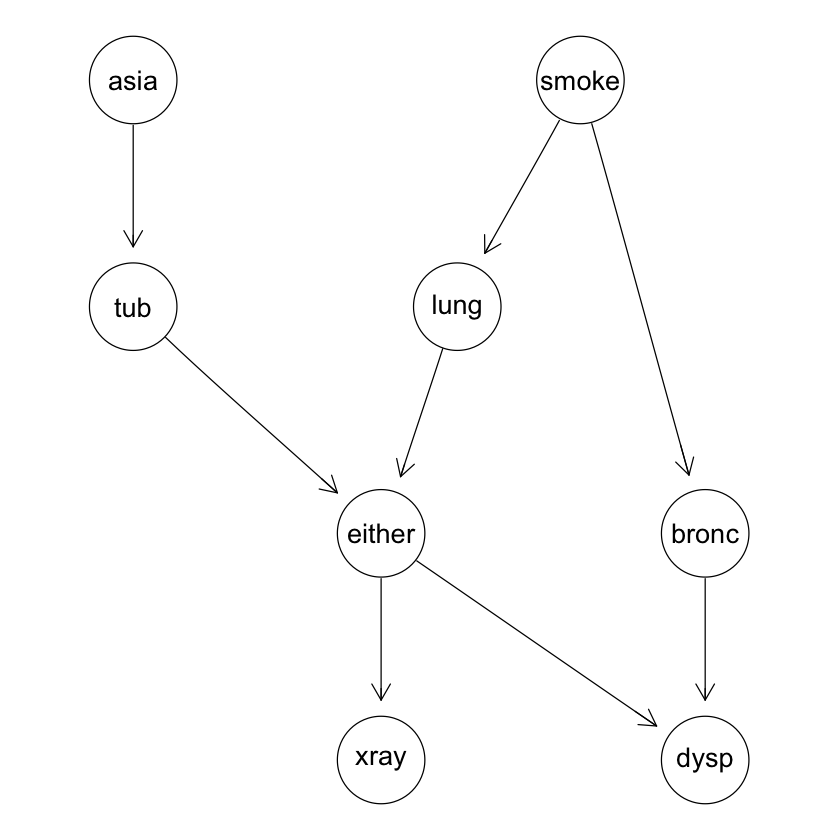

In [12]:
dag <- model2network('[smoke][asia][tub|asia][lung|smoke][bronc|smoke][either|tub:lung][dysp|bronc:either][xray|either]')
graphviz.plot(dag)
dataset <- read.csv('https://www.ccd.pitt.edu//wiki/images/ASIA10k.csv', header=T)
print(head(dataset))

#### K2 algorithm testing

After importing the dataset, we order its columns following the 'prior' information given on the relationship between variables, as requested by the K2 algorithm: 'smoke' and 'asia' variables are set as roots node, whereas 'xray' and 'dysp' are the leaves of the DAG.

In addition, we set the max number of parents to 2 for each node.

Finally, we test on this dataset the K2 algorithm we implemented in R, that leads to the following results:

$log.score
[1] -22270.82

$dag

  Random/Generated Bayesian network

  model:
   [asia][smoke][tub][lung|smoke][bronc|smoke][either|tub:lung][xray|either]
   [dysp|either:bronc]
  nodes:                                 8 
  arcs:                                  7 
    undirected arcs:                     0 
    directed arcs:                       7 
  average markov blanket size:           2.25 
  average neighbourhood size:            1.75 
  average branching factor:              0.88 

  generation algorithm:                  Empty 



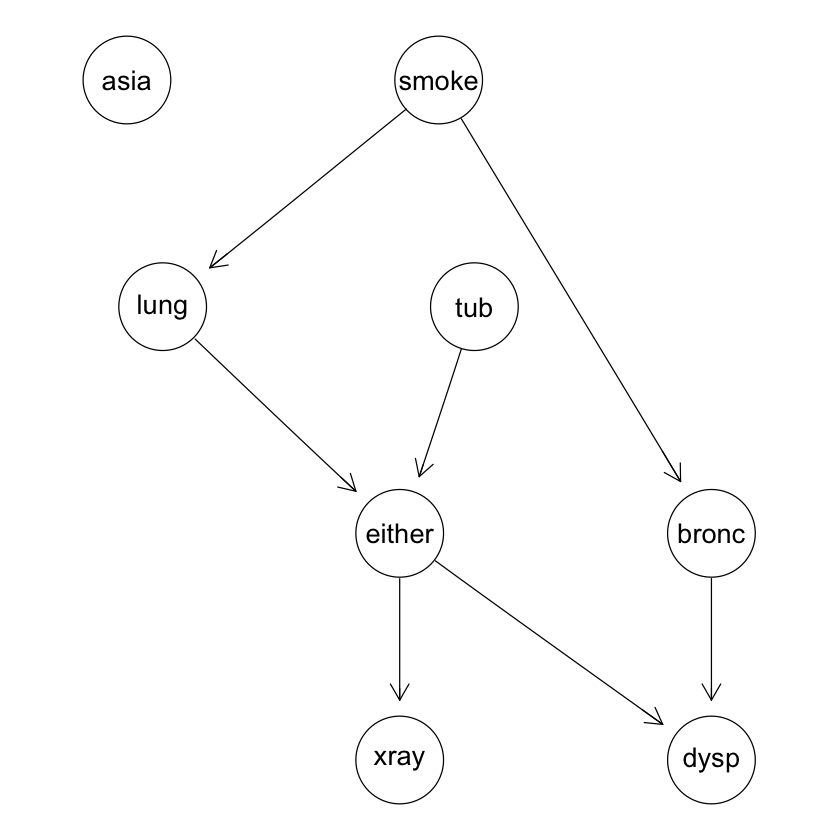

In [13]:
dataset[,] <- ifelse(dataset[,]=='yes',1,0)
col_order <- c('asia', 'smoke', 'tub', 'lung', 'either', 'bronc', 'xray', 'dysp')
dataset <- dataset[, col_order]
k2.algorithm(data=dataset, max.parents=2, output.prob=F)

As we can see, the network structure is inferred correctly except for the arch going from 'asia' to 'tub': to understand this behaviour we impose the theoretical structure of the network and compute the correspondent conditional probabilities, exploiting the fit() function of the 'bnlearn' built-in package.
It is possible to observe that for both the presence and the absence of the 'visit to asia' feature, the conditional probabilities of tuberculosis are comparable.


  Parameters of node tub (multinomial distribution)

Conditional probability table:
 
   asia
tub           a           p
  a 0.990084271 0.954054054
  p 0.009915729 0.045945946

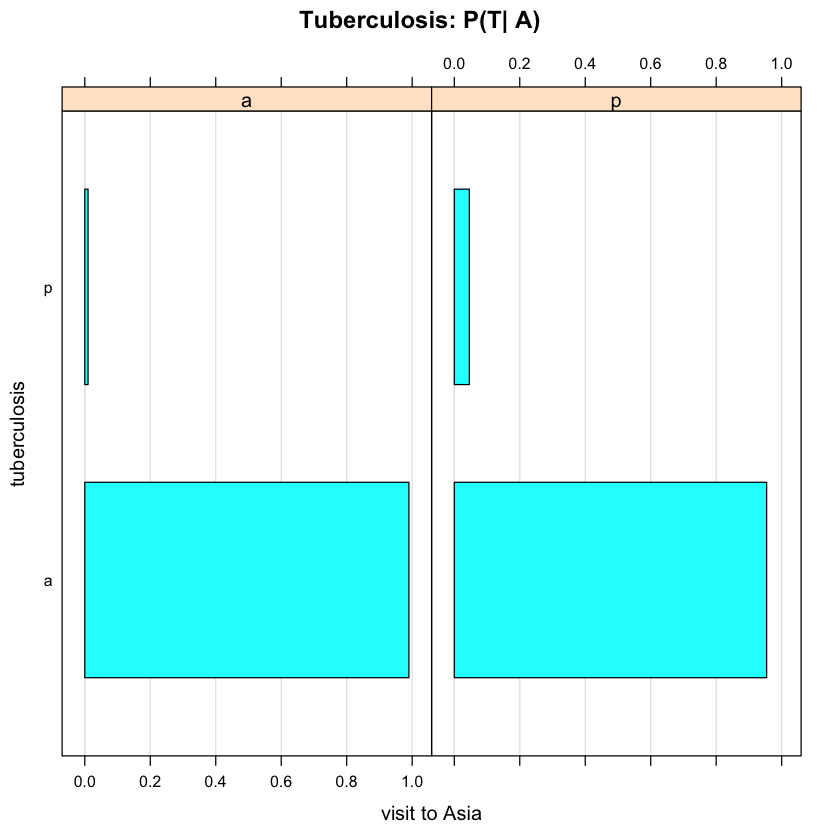

In [14]:
data.f <- data.frame(ifelse(dataset == 1, 'p', 'a'), stringsAsFactors = TRUE)
dag <- model2network('[smoke][asia][tub|asia][lung|smoke][bronc|smoke][either|tub:lung][dysp|bronc:either][xray|either]')
bn.bayes <- bn.fit(dag, data = data.f, method = "bayes")
bn.bayes$tub
bn.fit.barchart(bn.bayes$tub, main = "Tuberculosis: P(T| A)", xlab = "visit to Asia", ylab = "tuberculosis")


To get a quantitative indicator of the link between these features, we compare the k2 score obtained for both the expected complete structure and the partial one that has been inferred by our algorithm.

In [15]:
score_8archs <- score(dag, data = data.f, type = "k2")
dag_new <- drop.arc(dag, from = "asia", to = "tub")
score_7archs <- score(dag_new, data = data.f, type = "k2")
cat(sprintf('The k2 log-score for the k2 inferred dag is: %.2f \n', score_7archs))
cat(sprintf('The k2 log-score for the theoretical dag is: %.2f', score_8archs))


The k2 log-score for the k2 inferred dag is: -22270.82 
The k2 log-score for the theoretical dag is: -22270.91

Since the log-score computed starting from the inferred network is slightly higher than the one obtained from the theoretical one, the k2 algorithm returns the first option. However, we notice how the two results are really close, which means that different scoring methods could eventually lead to different outcomes.

To have a closer look at the behaviour, we perform an independence test for the two variables 'asia' and 'tub' with the following hypothesis:
* H$_0$: the two variables are independent, i.e., the test statistic, that in our case is the mutual information, is 0
* H$_1$: the mutual information is positive.

Performing the independence test with $\alpha=0.01$ we can accept $H_0$ at the 1% level of significance (with $p-value \sim 0.017$).

Moreover, the same test, performed on any other couple of variables that the K2 algorithm was able to recognise as conditional on each other, would have rejected $H_0$ ($p-value \sim10^{-16})$.

In [16]:
ci.test('asia', 'tub', test = 'mi', data = data.f)


	Mutual Information (disc.)

data:  asia ~ tub  
mi = 5.6746, df = 1, p-value = 0.01721
alternative hypothesis: true value is greater than 0


#### bnlearn structure learning

We now perform the structure guessing with the bnlearn hc() built-in function, that performs the network guessing with the hill-climbing algorithm. In addition, it is possible to choose the scoring function from a given set: we choose to test the 'k2' scoring function and the 'bde' scoring function. 
The 'k2' score retrieve the 'partial' network with the missing arch from 'asia' and 'tub' variables.
On the other hand, the BDe score guesses the proper structure. Then, we can visualize its strength plot and retrieve numerically the archs' strength:
the 'asia'-'tub' connection is from 3  to 4 orders of magnitude weaker than the other connections.



    from     to      strength
1  bronc   dysp -2719.0248634
2   lung either -2068.1423248
3 either   xray -1506.9648873
4    tub either  -537.3965664
5  smoke  bronc  -456.9110676
6 either   dysp  -285.4754725
7  smoke   lung  -206.1642211
8   asia    tub    -0.5863799


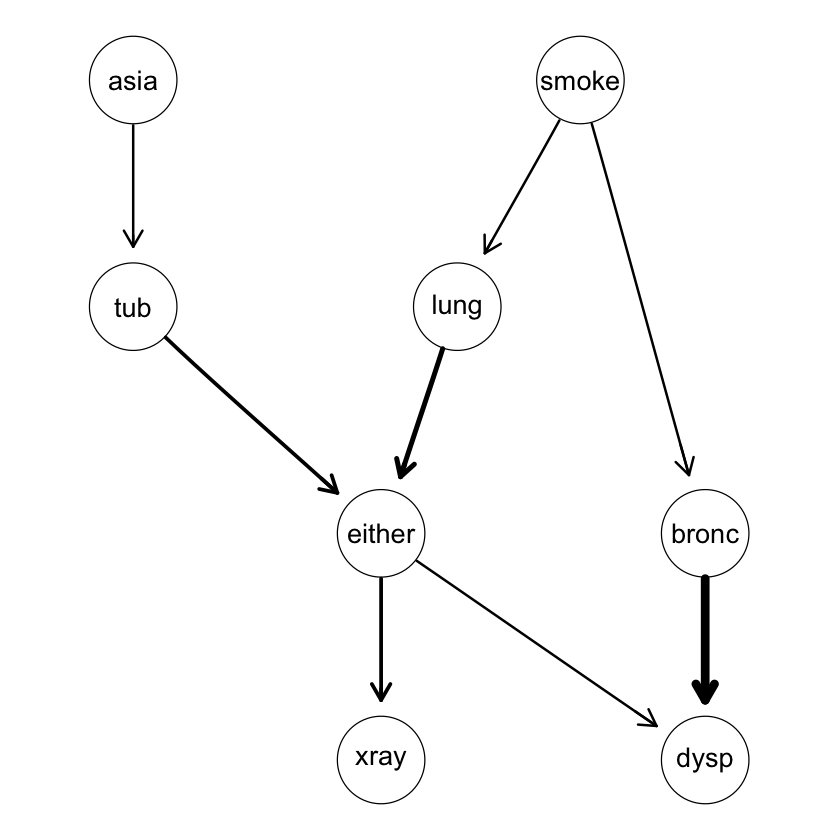

In [17]:
fit_bde <- hc(data.f, score = 'bde', maxp = 2)

strength.plot(fit_bde, arc.strength(fit_bde, data.f))
print(arc.strength(fit_bde, data.f))

#### bnctruct K2 score implementation: test with Asia dataset

Now, we test our implementation of the K2 scoring function inside the bnstruct library on top of the hill-climbing algorithm. 
Again, the k2 scoring is not able to guess the weak 'tuberculosis' vs 'asia' dependence, but retrieves, all in all, the correct graph.

bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



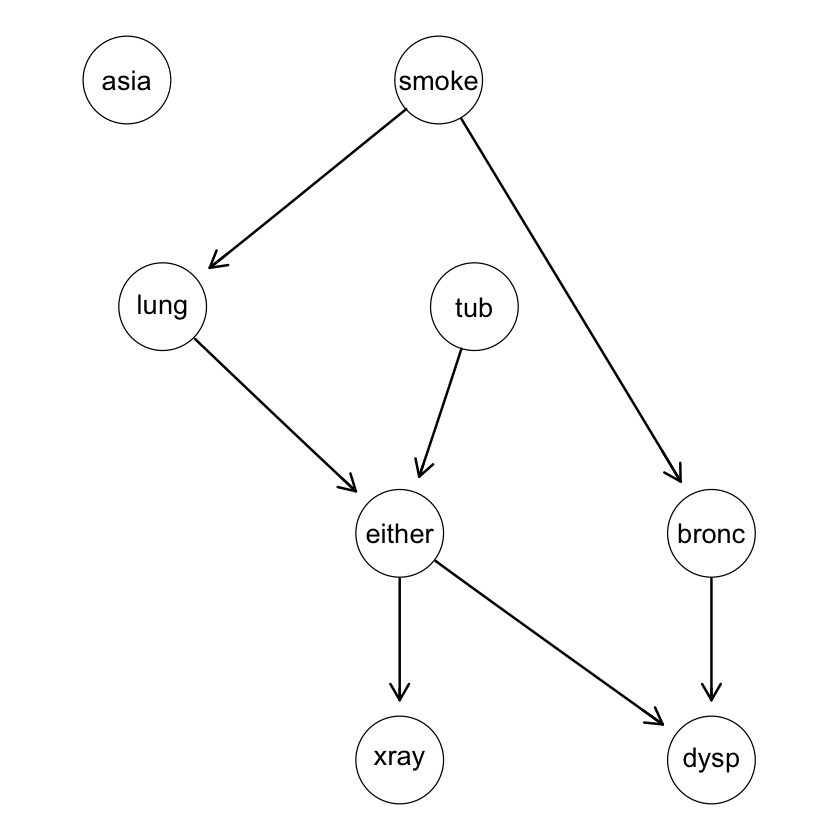

In [18]:
BNasia <- BNDataset(data = dataset,
                discreteness = rep('d', ncol(dataset)),
                variables = names(dataset),
                node.sizes = rep(c(2), 8) ,
                starts.from = 0)

bnet <- learn.network(BNasia, algo='hc', scoring='k2',layering=1:8)
plot(bnet)

#### bnctruct k2 algorithm implementation: test with Asia dataset

Finally, we test the implementation of the whole K2 method on the 'Asia' dataset.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Bayesian Network: BNDataset

num.nodes 8

variables
asia smoke tub lung either bronc xray dysp
discreteness
TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
node.sizes
2 2 2 2 2 2 2 2
Adjacency matrix:
       asia smoke tub lung either bronc xray dysp
asia      0     0   0    0      0     0    0    0
smoke     0     0   0    1      0     1    0    0
tub       0     0   0    0      1     0    0    0
lung      0     0   0    0      1     0    0    0
either    0     0   0    0      0     0    1    1
bronc     0     0   0    0      0     0    0    1
xray      0     0   0    0      0     0    0    0
dysp      0     0   0    0      0     0    0    0

Conditional probability tables:$asia
asia
          1           2 
0.990750925 0.009249075 

$smoke
smoke
        1         2 
0.5045995 0.4954005 

$tub
tub
         1          2 
0.98975102 0.01024898 

$lung
     lung
smoke         1          2
    1 0.9892500 0.01075002
    2 0.9026642 0.09733576

$either
, , either = 1

   lung
tub           1     

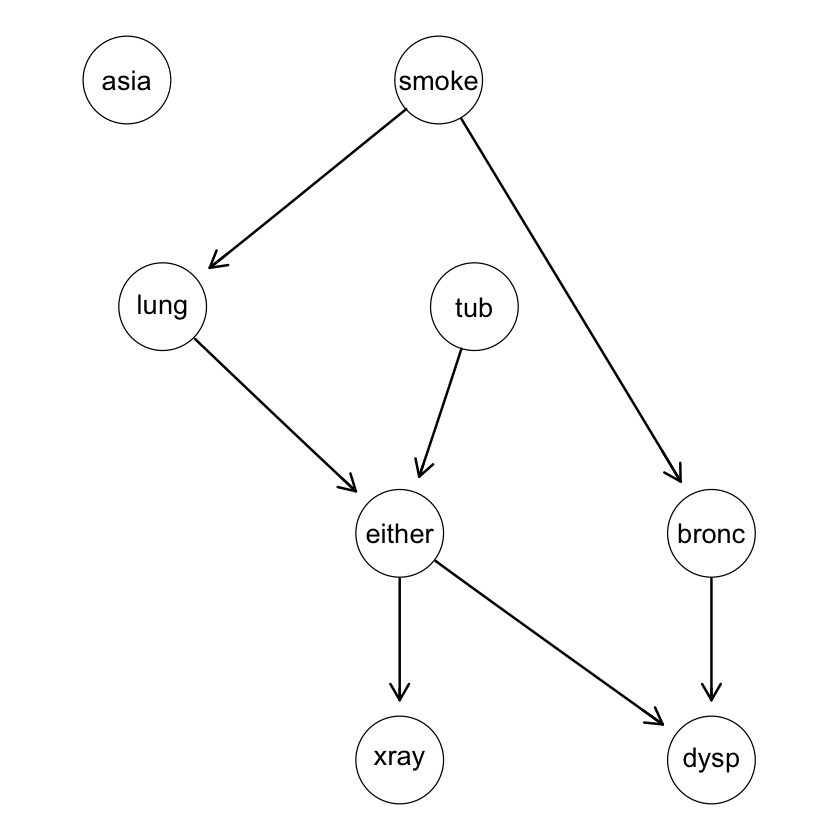

In [19]:
BNDasia <- BNDataset(data = dataset,
                discreteness = rep('d', ncol(dataset)),
                variables = names(dataset),
                node.sizes = rep(c(2), 8),
                starts.from = 0)

K2 <- k2.learn.net(BNDasia,2)
K2
plot(K2)

## References

1. [_Gregory F. Cooper, Edward Herskovits, 'A Bayesian method for the induction of probabilistic networks from data'_](https://link.springer.com/article/10.1007/BF00994110)

2. [_Carolina Ruiz, 'Illustration of the K2 Algorithm for Learning Bayes Net Structures'_](http://web.cs.wpi.edu/~cs539/s05/Projects/k2_algorithm.pdf)

3. [_Francesco Sambo, Alberto Franzin, 'bnstruct:  an R package for Bayesian Network Structure Learning with missing data'_](https://mran.microsoft.com/snapshot/2016-11-18/web/packages/bnstruct/vignettes/bnstruct.pdf)

4. [_Marco Scrutari, 'Dirichlet Bayesian Network Scores and the Maximum Relative Entropy Principle'_](https://arxiv.org/abs/1708.00689)

5. [_S.L.Lauritzen, D.J.Spiegelhalter, 'Local Computations with Probabilities on Graphical Structures and Their Application to Expert Systems '_](https://www.jstor.org/stable/2345762?seq=1#metadata_info_tab_contents)

6. [_Marco Scrutari et al., 'Who Learns Better Bayesian Network Structures: Accuracy and Speed of Structure Learning Algorithms'_](https://arxiv.org/abs/1805.11908)

<a id="reference_cell"></a>
